# GPA - Geometric Pose Affordance: 3D Human Pose with Scene Constraints

### Objective

__Explore different gestures__

### Import Libraries

In [1]:
#### check data is correct(multi layer depth map), geometry valid, and visualze the joint (15 joints setting)
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import cv2
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model

### Load Data

In [2]:
test_3d_gt_rel_std = np.load('test/test_3d_gt_rel_std.npy')
test_3d_gt_rel_mean = np.load('test/test_3d_gt_rel_mean.npy')
gt_3d_train_rel = np.load('train/gt_3d_train_rel.npy')
train_3d_gt_rel_std = np.load('train/train_3d_gt_rel_std.npy')
train_3d_gt_rel_mean = np.load('train/train_3d_gt_rel_mean.npy')
test_2d_gt_std = np.load('test/test_2d_gt_std.npy')
test_2d_gt_mean = np.load('test/test_2d_gt_mean.npy')
train_2d_gt_std = np.load('train/train_2d_gt_std.npy')
train_2d_gt_mean = np.load('train/train_2d_gt_mean.npy')
gt_2d_test = np.load('test/gt_2d_test.npy')
gt_2d_train = np.load('train/gt_2d_train.npy')
J_test_gt_mdp_enc2_15 = np.load('test/J_test_gt_mdp_enc2_15.npy')
J_train_gt_mdp_enc2_15 = np.load('train/J_train_gt_mdp_enc2_15.npy')
J_test_gt_mdp_15 = np.load('test/J_test_gt_mdp_15.npy')
J_train_gt_mdp_15 = np.load('train/J_train_gt_mdp_15.npy')
test_gt_mdp_15 = np.load('test/test_gt_mdp_15.npy')
train_gt_mdp_15 = np.load('train/train_gt_mdp_15.npy')
gt_2d_val = np.load('validation/gt_2d_val.npy')
gt_3d_val_rel = np.load('validation/gt_3d_val_rel.npy')

### Define Plotting Functions

In [3]:
def show2D(points):
    points = ((points.reshape(16, -1))).astype(np.int32)
    img = np.ones((256,256)) * 50
    for j in range(16):
        if j == 7:
            continue
        img = cv2.circle(img, tuple(points[j, :].astype(int)), 3,  (255, 0, 0), cv2.FILLED)
    edges_left = [[0, 1], [1, 2], [2, 6], [10, 11], [12, 8], [11, 12]]
    edges_middle = [[6, 8],[8, 9]]
    edges = [[0, 1], [1, 2], [2, 6], [6, 3], [3, 4], [4, 5],
         [10, 11], [11, 12], [12, 8], [8, 13], [13, 14], [14, 15],
         [6, 8], [8, 9]]
    for e in edges:
        if e in edges_left:  ## right and middle: red, left: blue
            cv2.line(img, (points[e[0], 0], points[e[0], 1]),
                  (points[e[1], 0], points[e[1], 1]), [0, 0, 255], 2)
        elif e in edges_middle:    
            cv2.line(img, (points[e[0], 0], points[e[0], 1]),
                  (points[e[1], 0], points[e[1], 1]), [128, 0, 128], 2)  
        else:
            cv2.line(img, (points[e[0], 0], points[e[0], 1]),
                  (points[e[1], 0], points[e[1], 1]), [255, 0, 0], 2) 
    return img

In [4]:
def vis_3d_skeleton(kpt_3d_gt_old): 
    kpt_3d = np.zeros((16, 3))
    kpt_3d[:6, :] = kpt_3d_gt_old[:6, :]
    kpt_3d[7:, :] = kpt_3d_gt_old[6:, :]
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection = '3d')
    for j in range(16):
        if j == 7:
            continue
        ax.scatter(kpt_3d[j, 0], kpt_3d[j, 2], -kpt_3d[j, 1], c = 'k', marker = 'o')
    edges_left = [[0, 1], [1, 2], [2, 6], [10, 11], [12, 8], [11, 12]]
    edges_middle = [[6, 8], [8, 9]]
    edges = [[0, 1], [1, 2], [2, 6], [6, 3], [3, 4], [4, 5],
             [10, 11], [11, 12], [12, 8], [8, 13], [13, 14], [14, 15],
             [6, 8], [8, 9]]
    for l in range(len(edges)):
        i1 = edges[l][0]
        i2 = edges[l][1]

        x2 = np.array([kpt_3d[i1, 0], kpt_3d[i2, 0]])
        y2 = np.array([kpt_3d[i1, 1], kpt_3d[i2, 1]])
        z2 = np.array([kpt_3d[i1, 2], kpt_3d[i2, 2]])        
        if edges[l] in edges_left:
            ax.plot(x2, z2, -y2, c = 'b', linewidth = 2)
        elif edges[l] in edges_middle:    
            ax.plot(x2, z2, -y2, c = 'm', linewidth = 2)
        else:
            ax.plot(x2, z2, -y2, c = 'r', linewidth = 2)

    all_joints = kpt_3d
    all_joints[:, 1] *= -1
    bb_min = all_joints.min(axis = 0)
    bb_max = all_joints.max(axis = 0)
    bb_center = (bb_max + bb_min) * 0.5
    max_dist = np.abs(bb_max - bb_min).max() / 2
    bb_min, bb_max = bb_center - max_dist, bb_center + max_dist
    ax.set_xlim([bb_min[0], bb_max[0]])
    ax.set_ylim([bb_min[2], bb_max[2]])
    ax.set_zlim([bb_min[1], bb_max[1]])

    # Z and Y are swapped
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_zlabel('Y')

    ax.view_init(elev = 11, azim = -82)
    plt.title('Output: Person in 3d unit mm space')

### Plotting different gestures

Plotting Person with ID 0


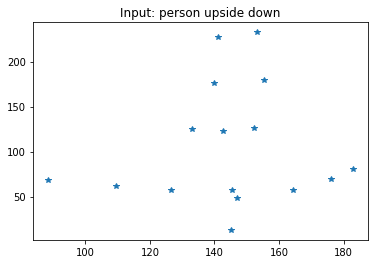

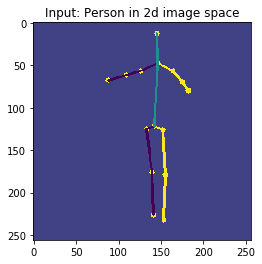

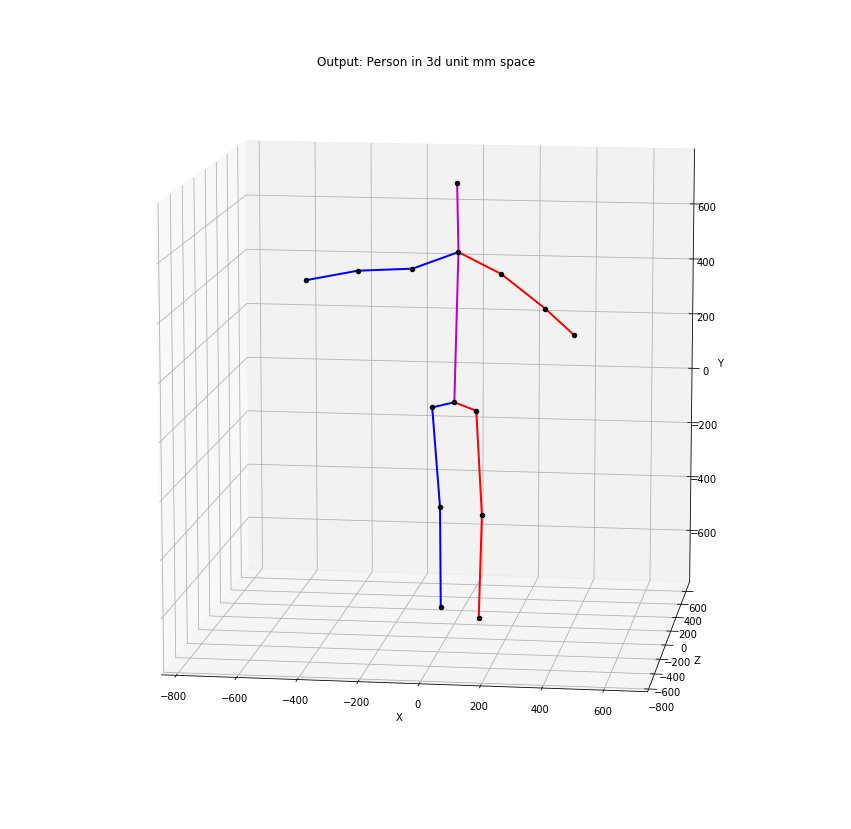

Plotting Person with ID 1


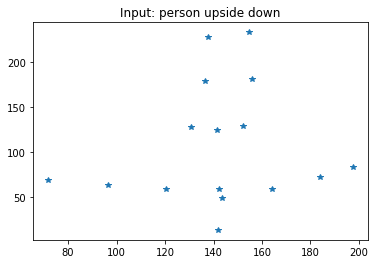

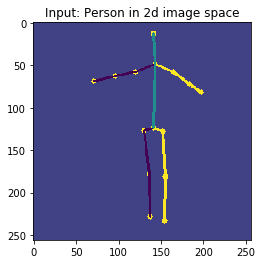

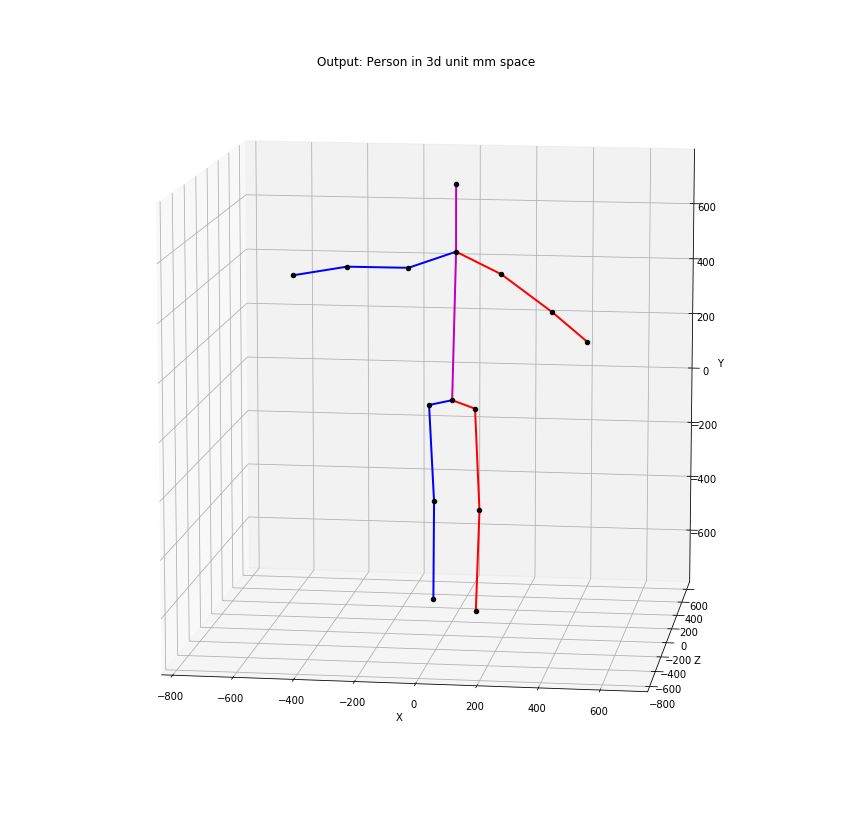

Plotting Person with ID 2


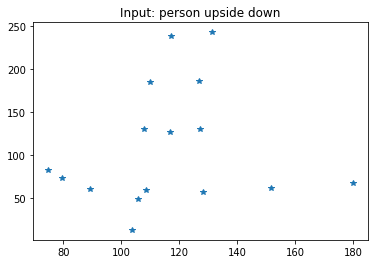

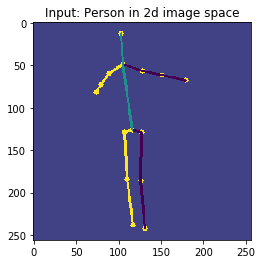

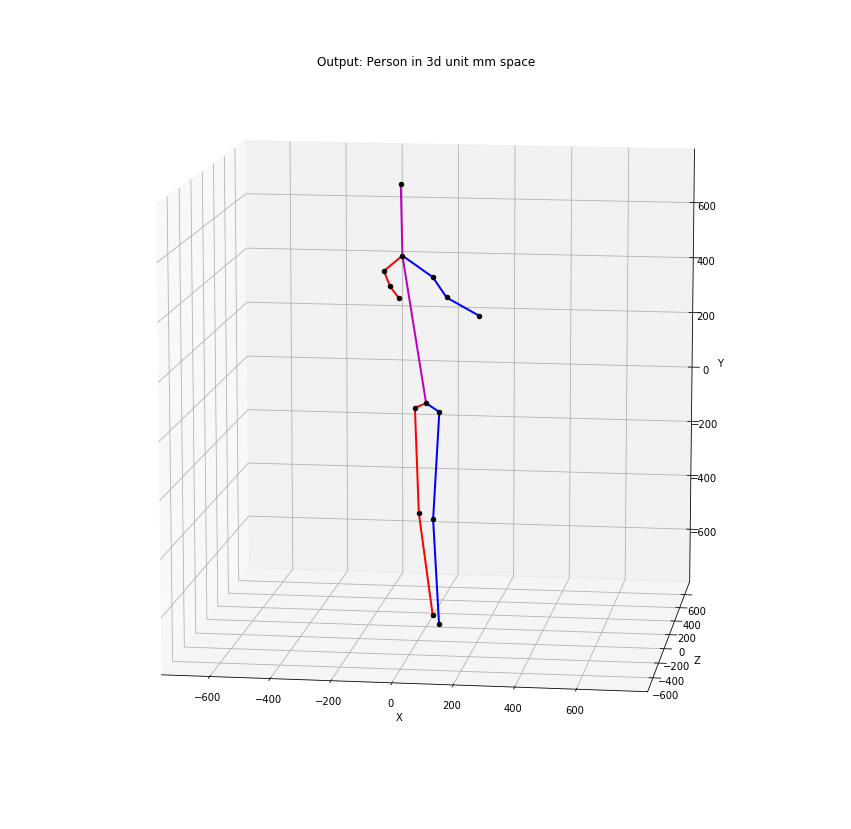

Plotting Person with ID 3


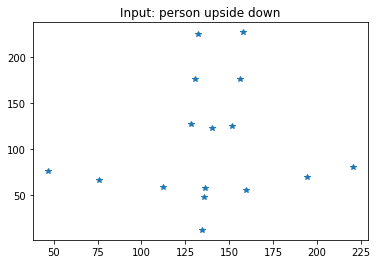

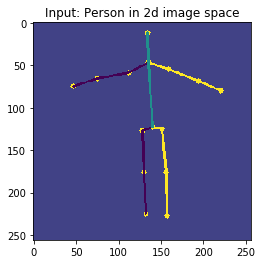

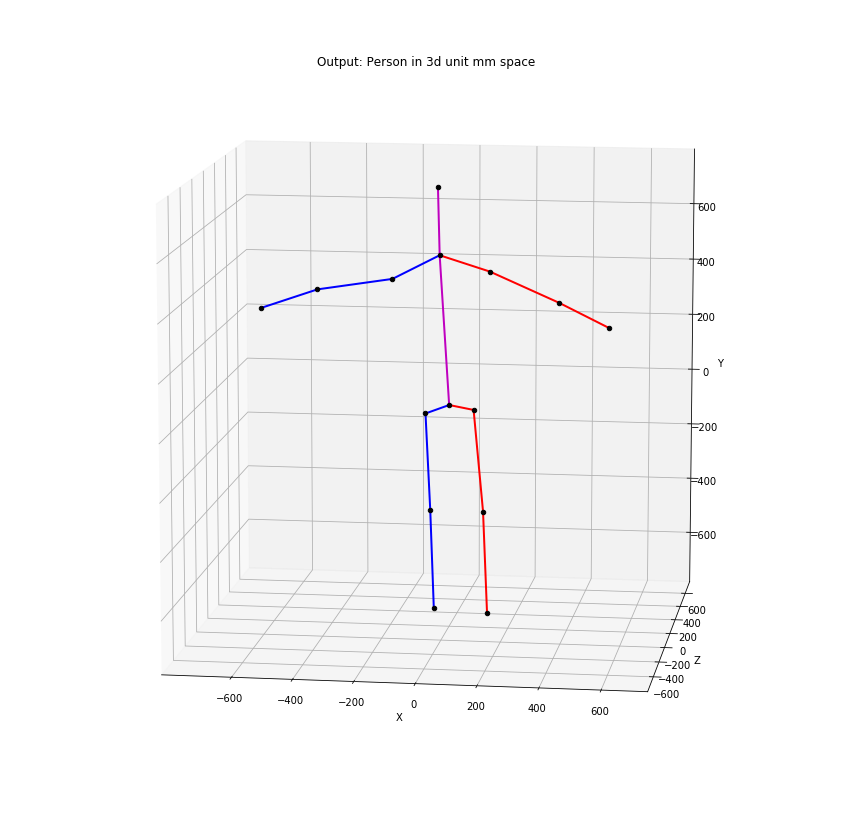

Plotting Person with ID 4


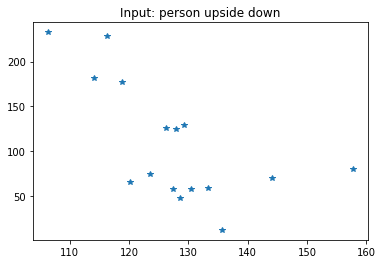

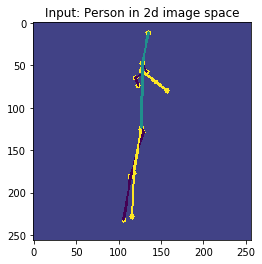

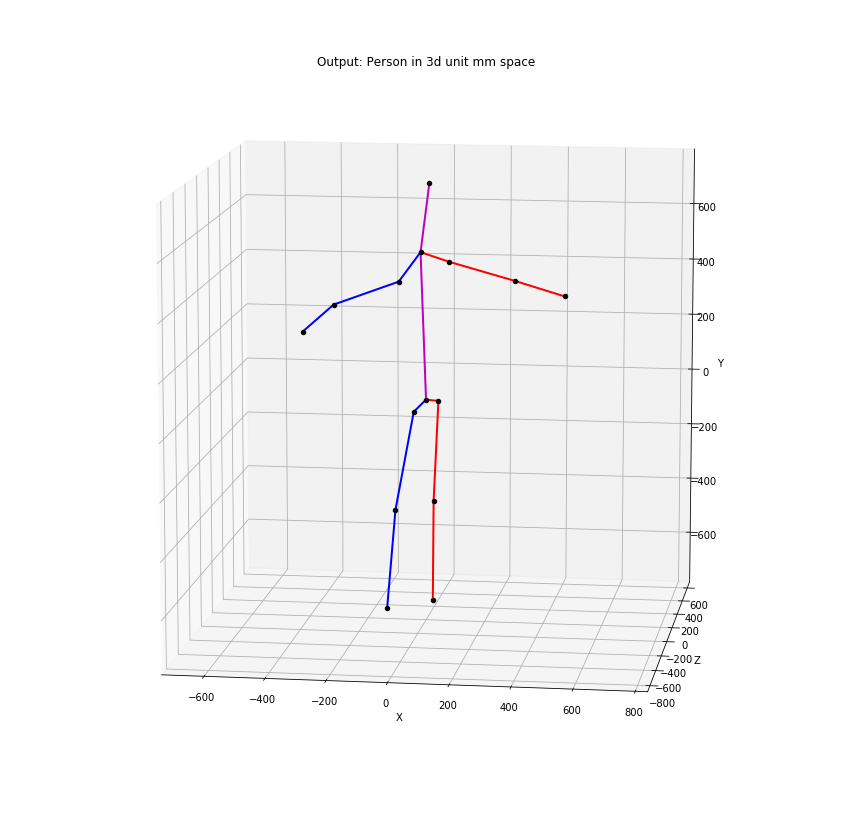

Plotting Person with ID 5


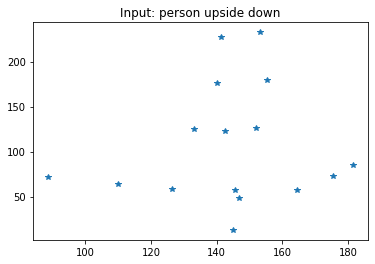

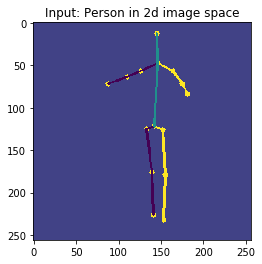

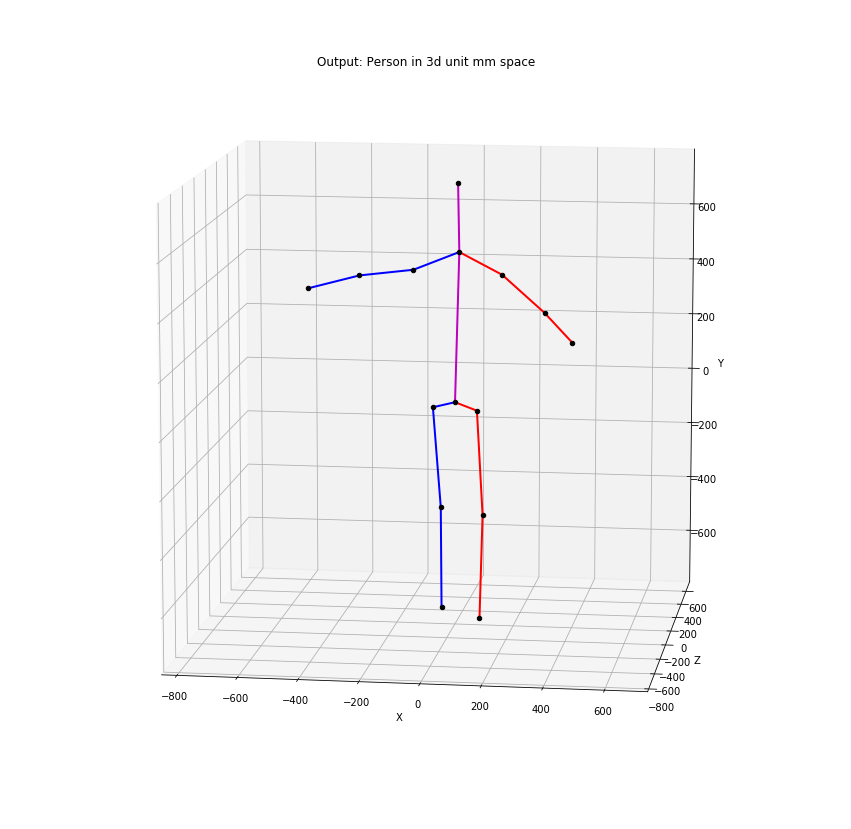

Plotting Person with ID 6


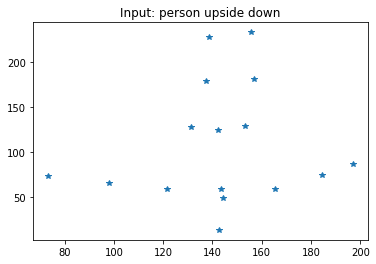

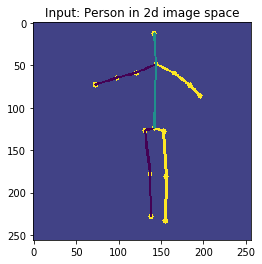

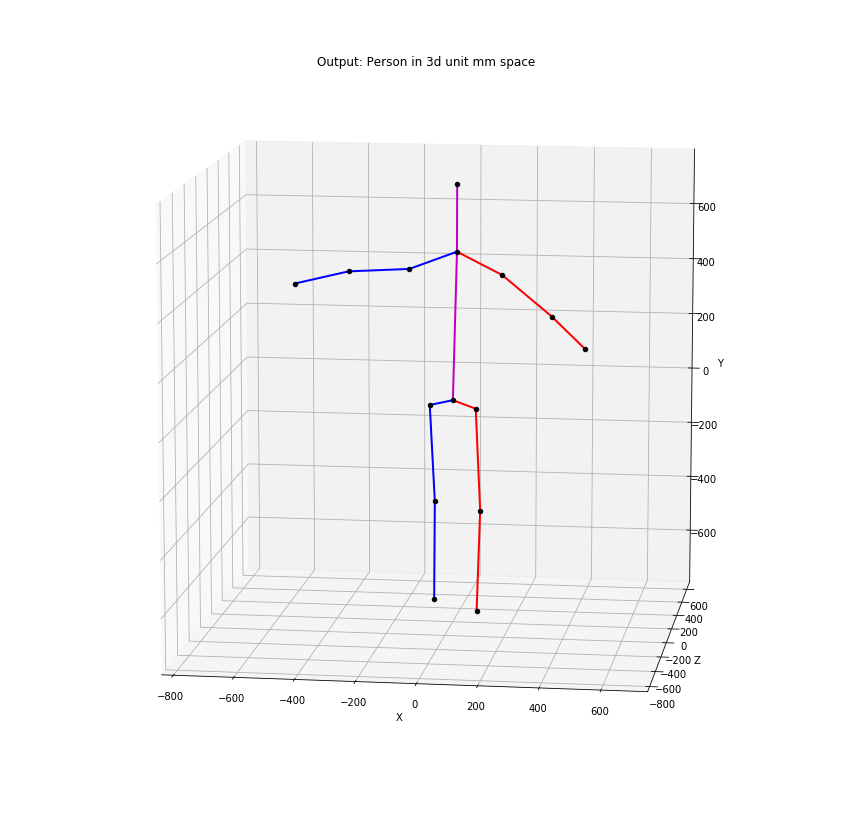

Plotting Person with ID 7


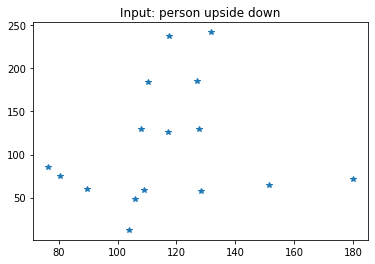

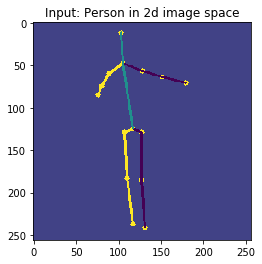

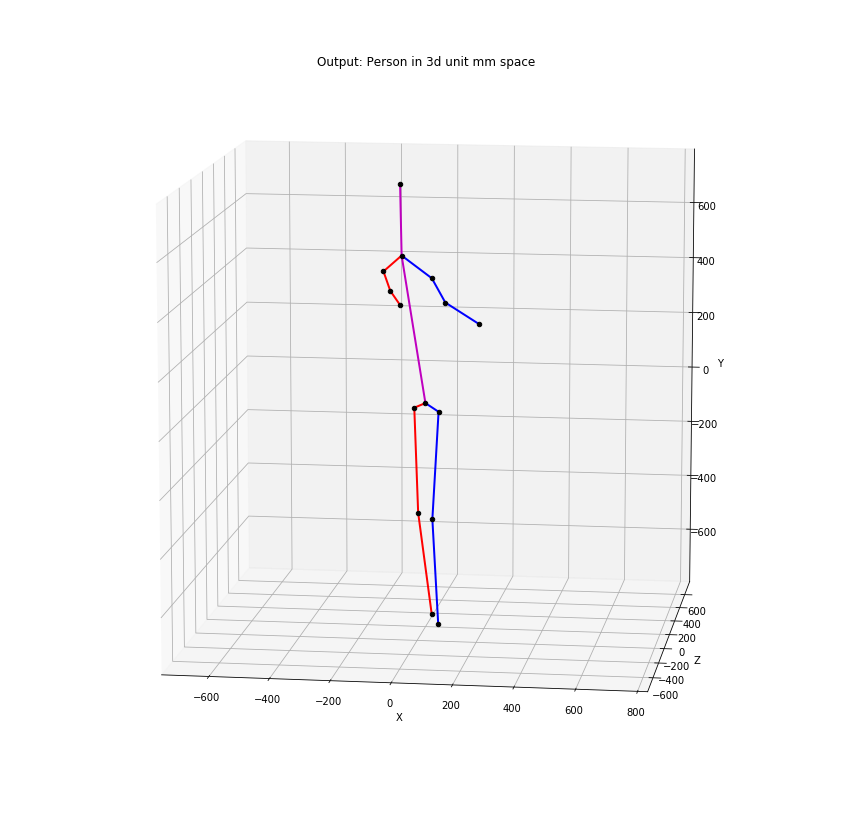

Plotting Person with ID 8


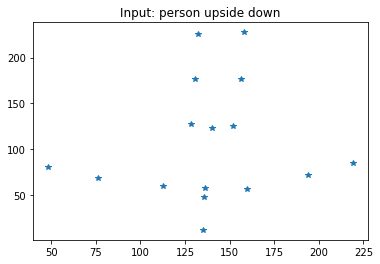

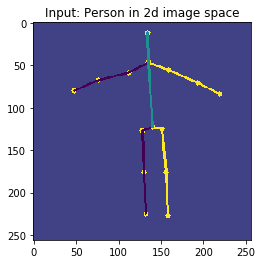

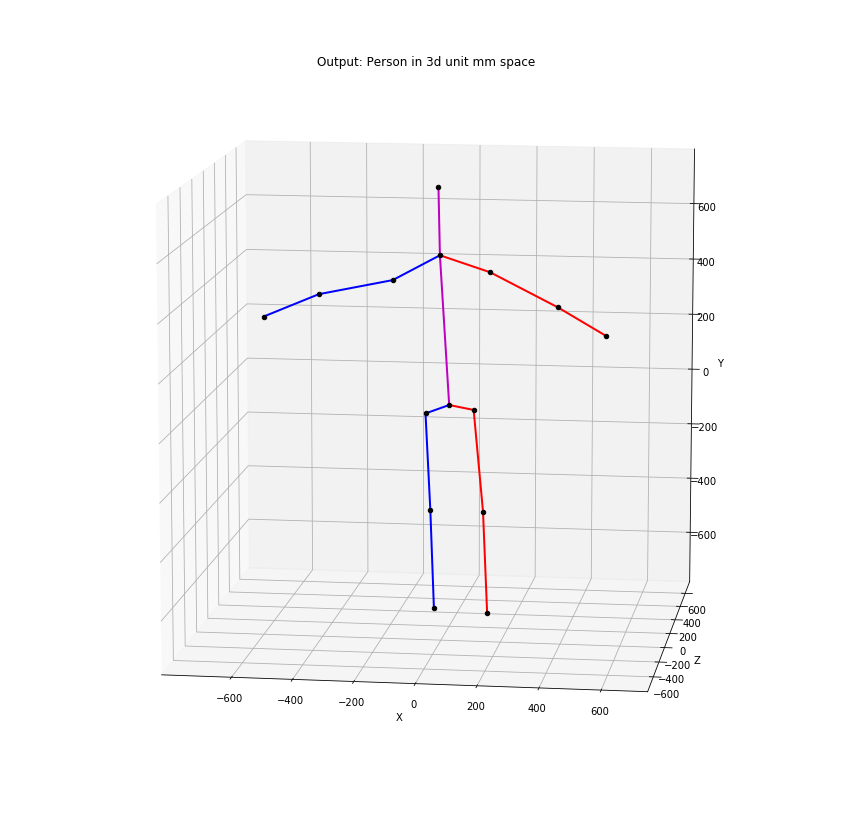

Plotting Person with ID 9


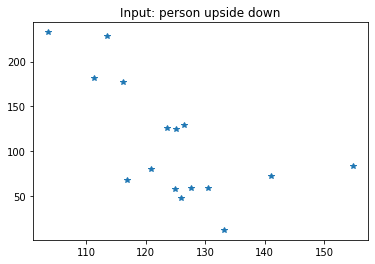

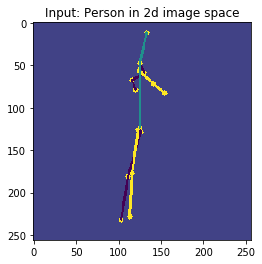

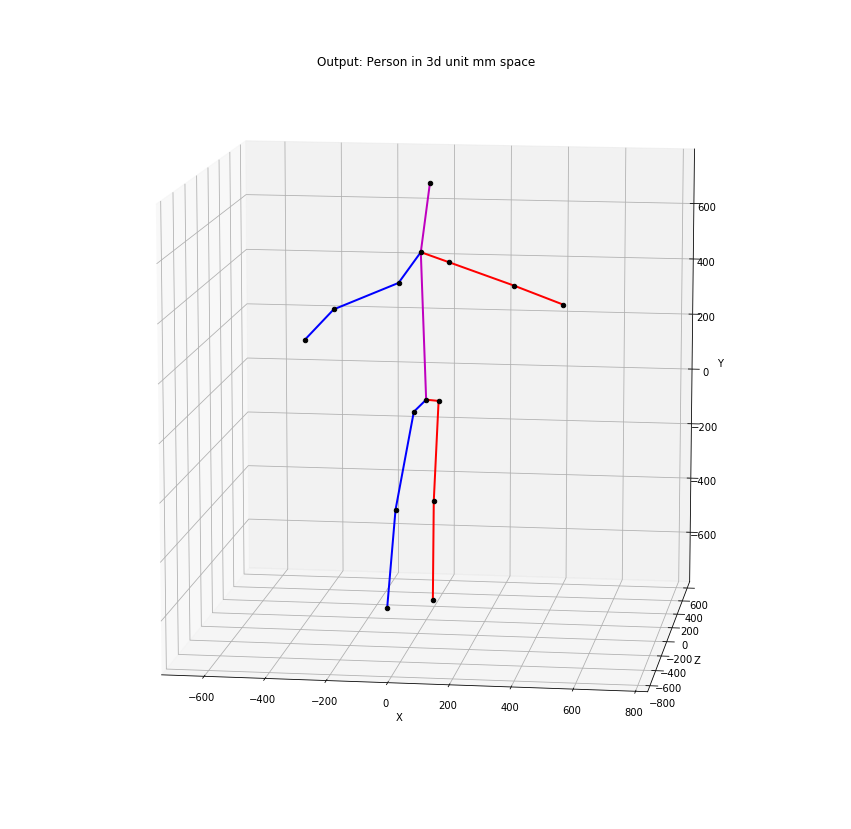

Plotting Person with ID 10


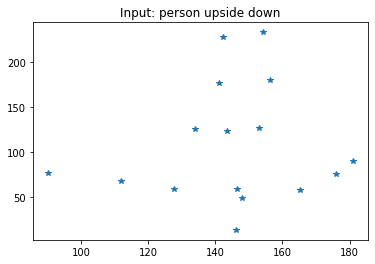

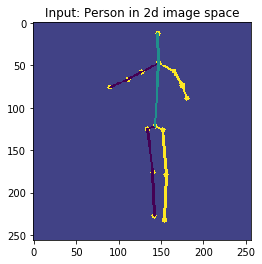

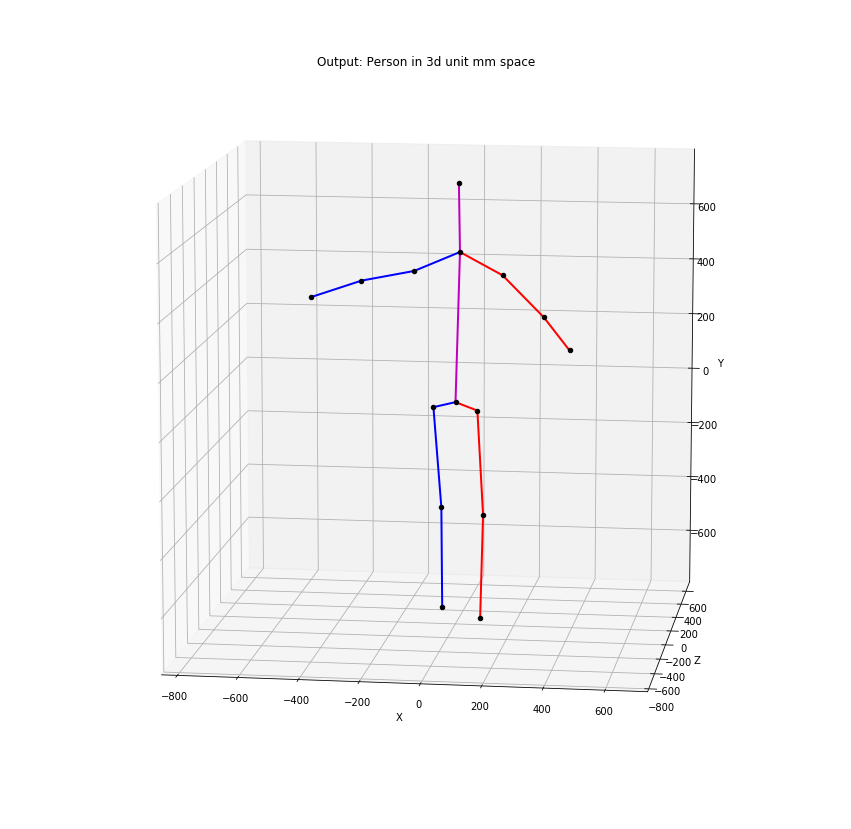

Plotting Person with ID 11


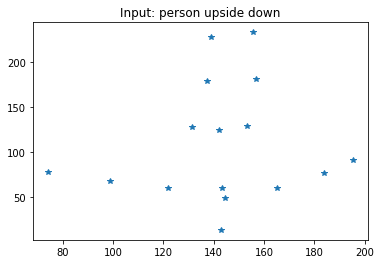

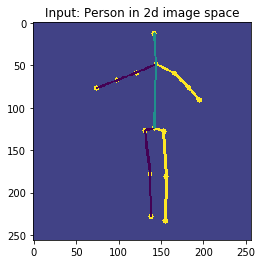

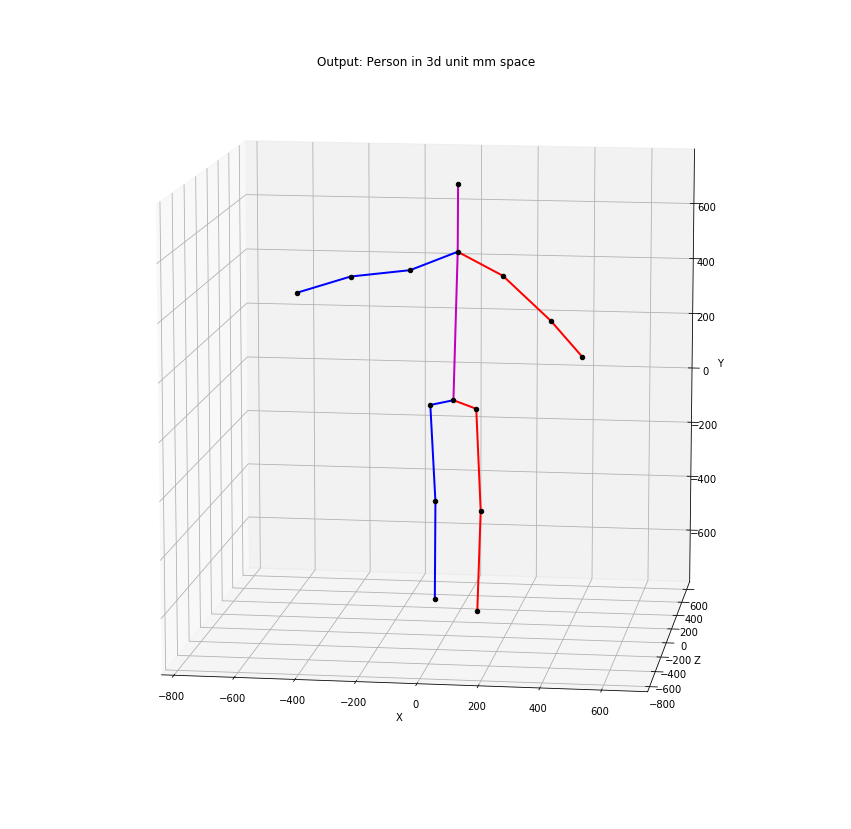

Plotting Person with ID 12


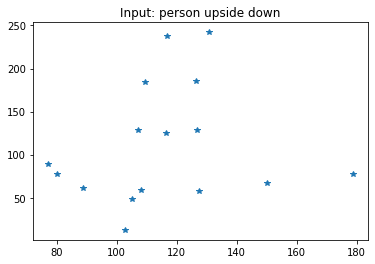

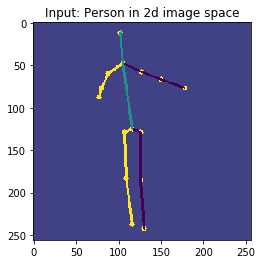

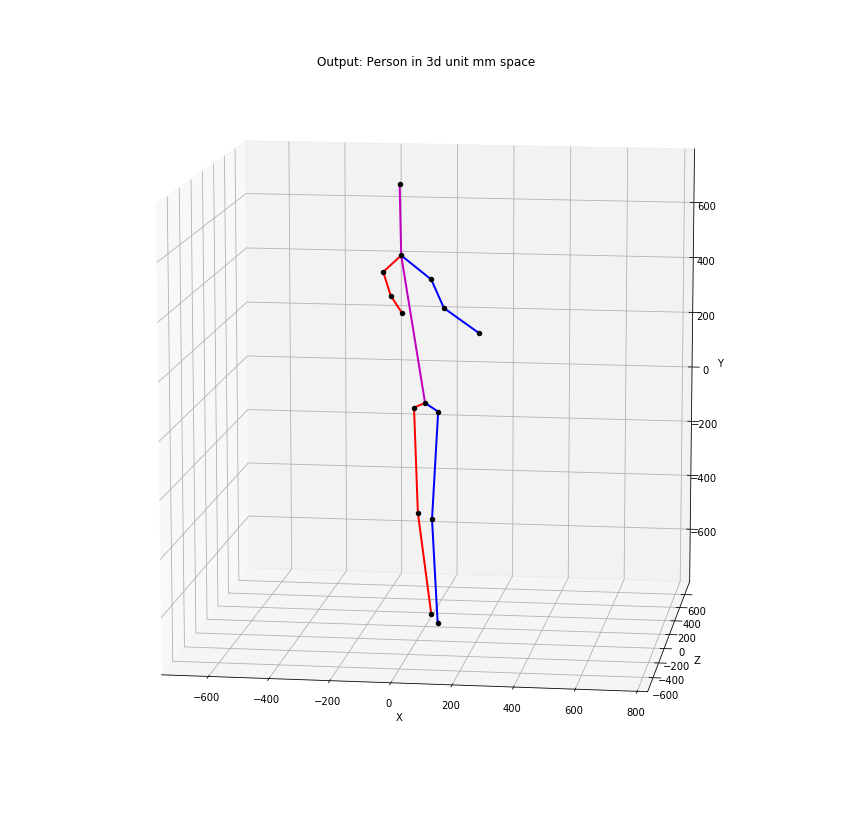

Plotting Person with ID 13


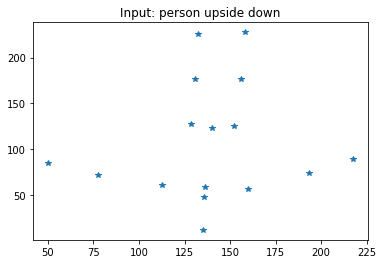

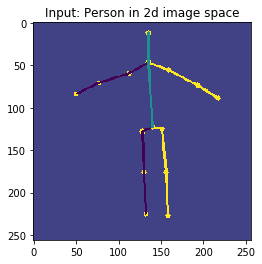

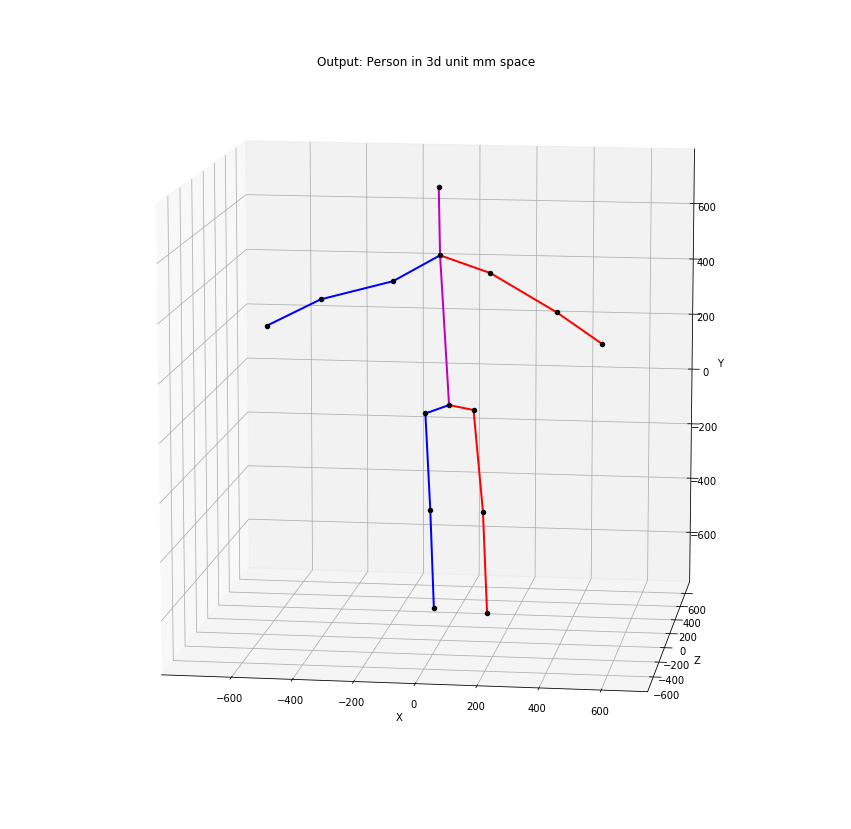

Plotting Person with ID 14


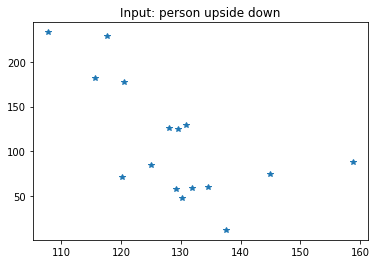

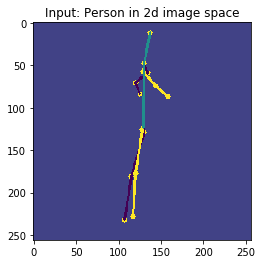

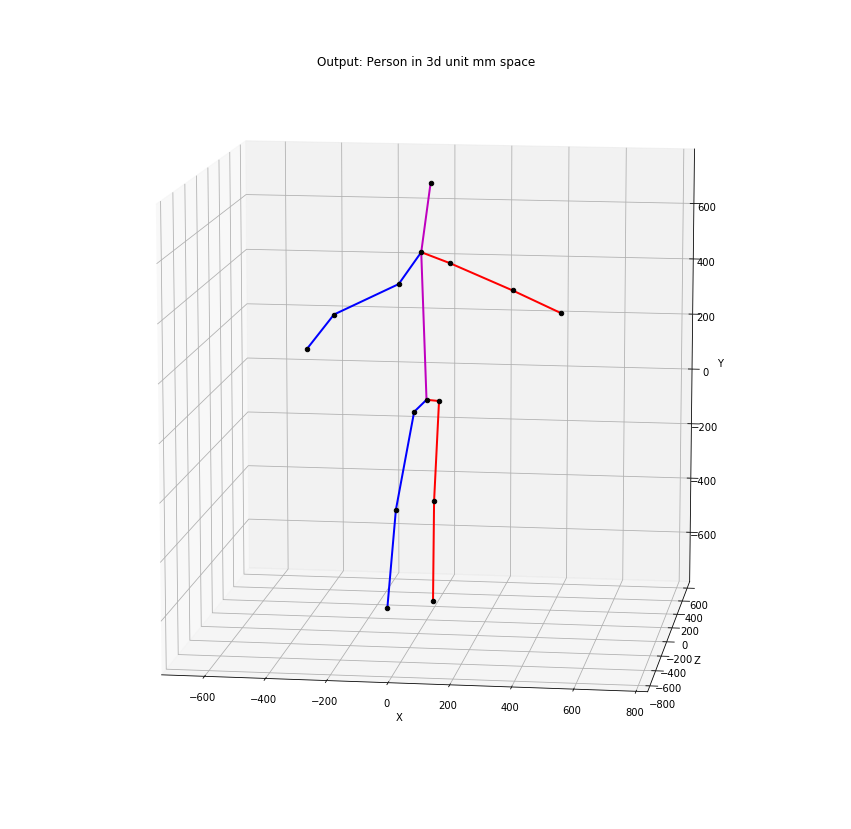

Plotting Person with ID 15


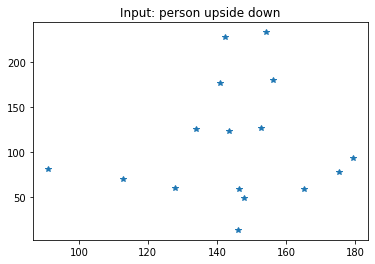

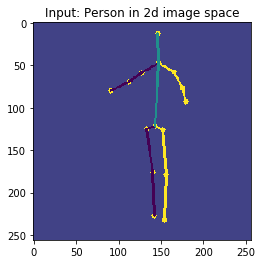

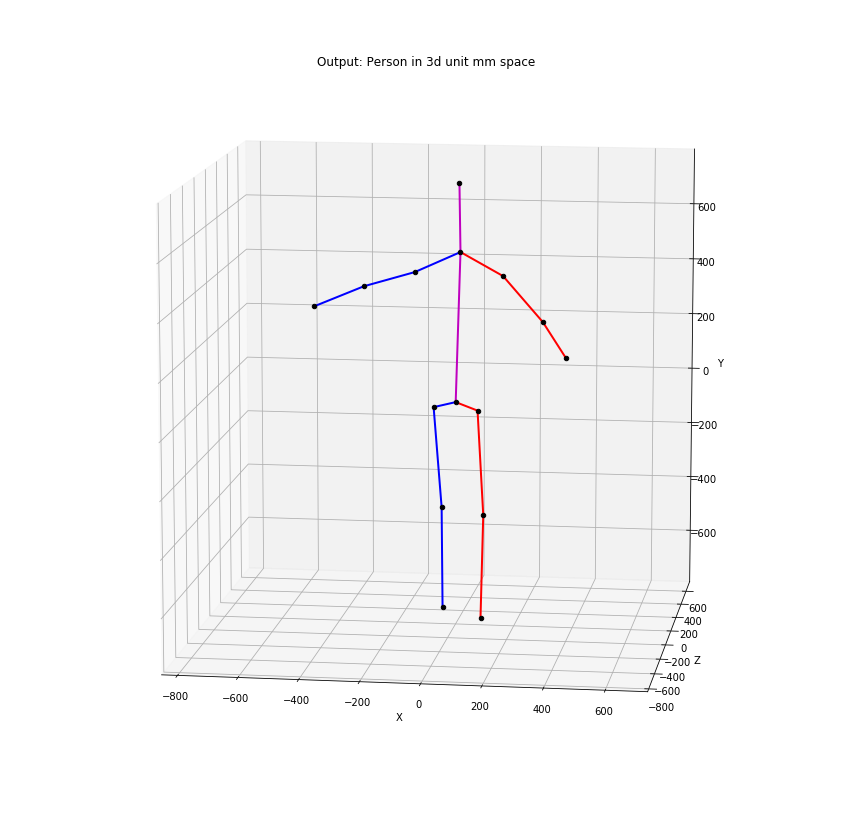

Plotting Person with ID 16


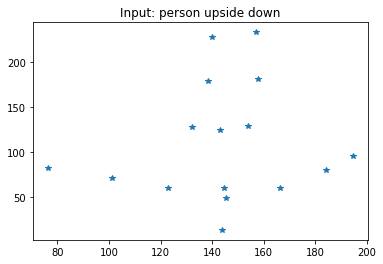

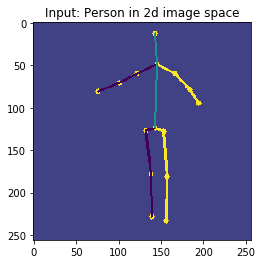

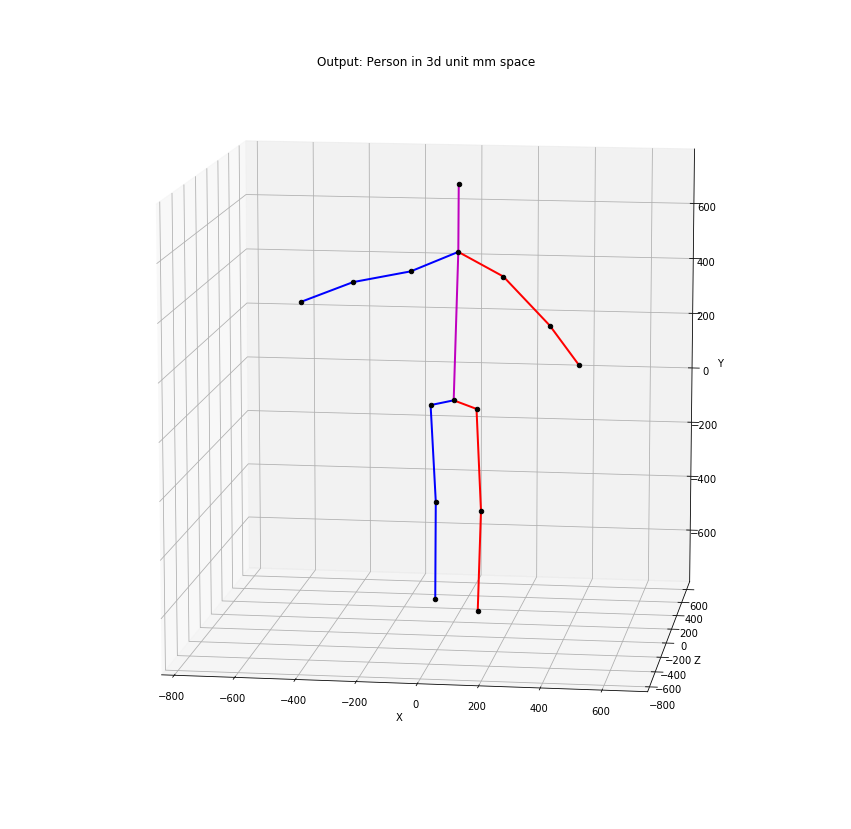

Plotting Person with ID 17


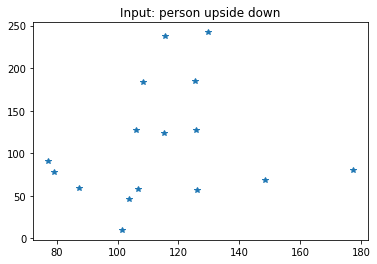

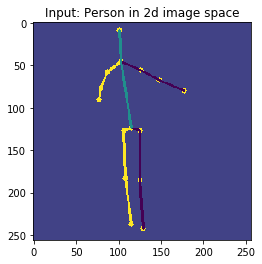

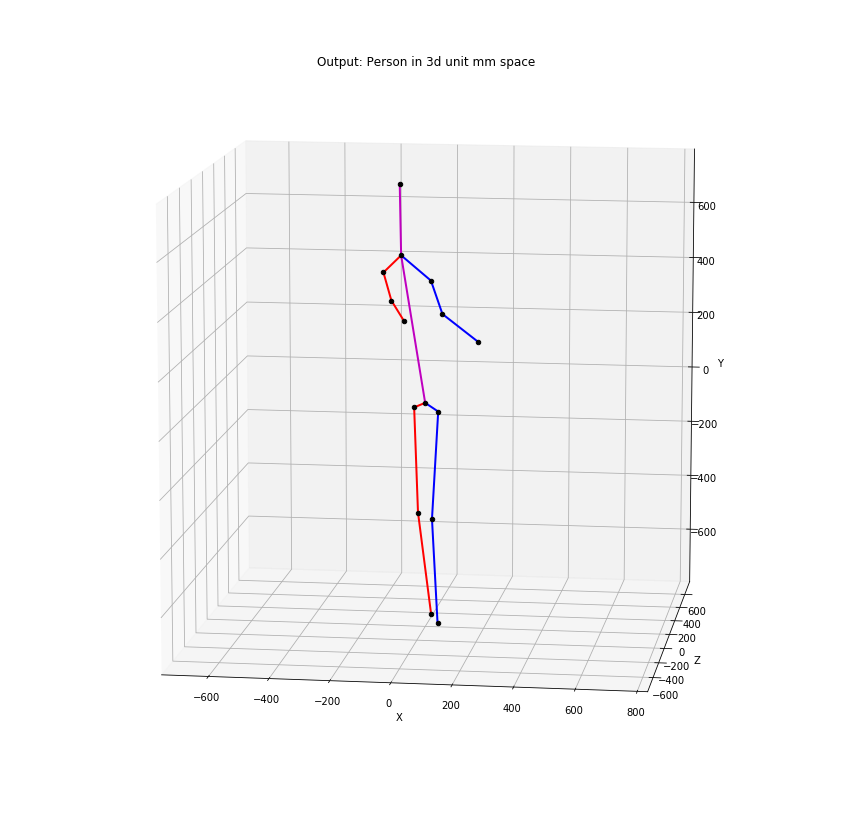

Plotting Person with ID 18


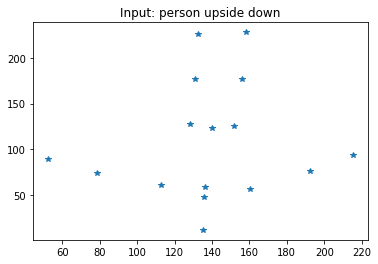

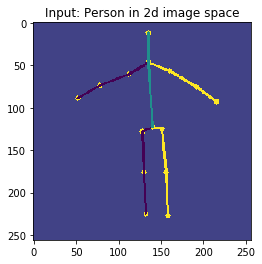

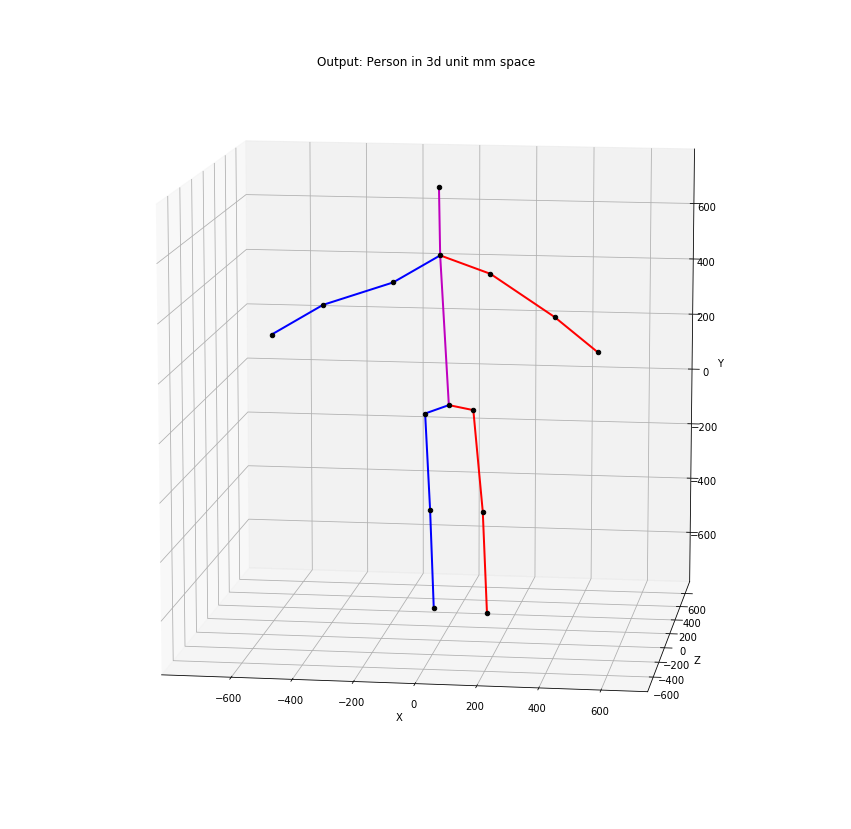

Plotting Person with ID 19


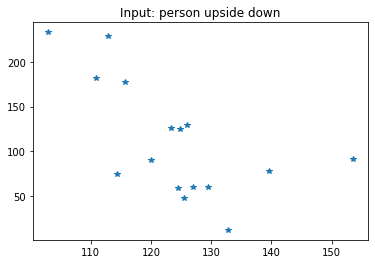

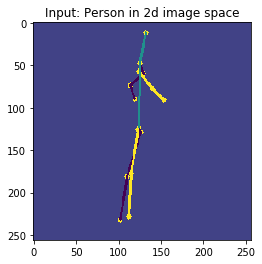

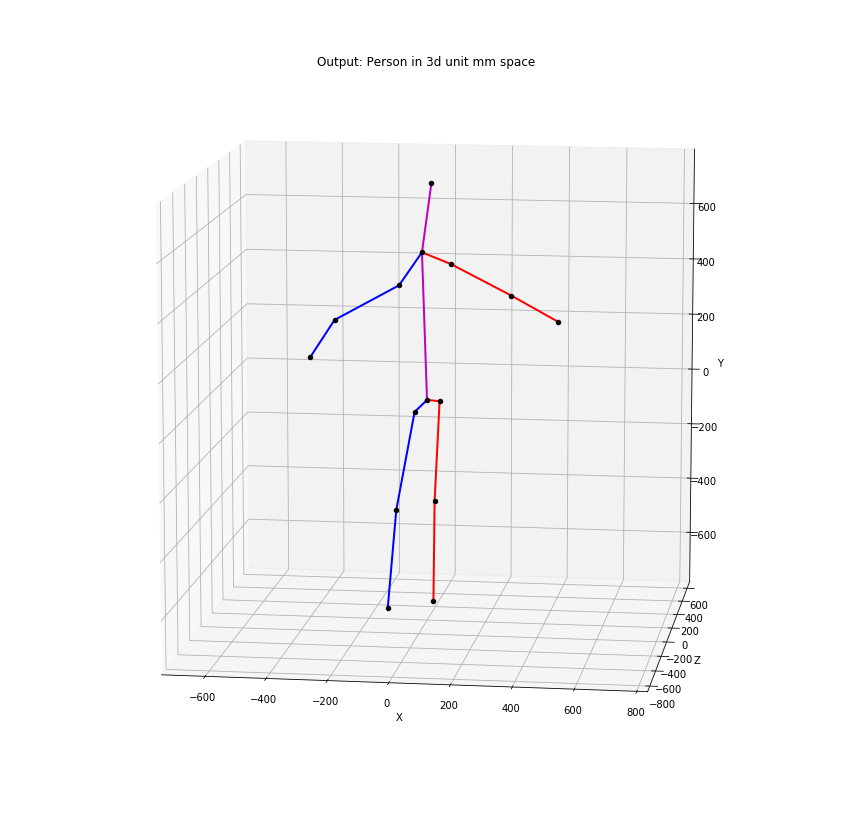

In [5]:
number_of_person = 20
for sample_id in range(number_of_person):
    print("Plotting Person with ID", sample_id)
    sample_2d = gt_2d_train[sample_id, ...]
    sample_3d = gt_3d_train_rel[sample_id, ...]
    plt.plot(sample_2d[:, 0],sample_2d[:, 1], '*')
    plt.title('Input: person upside down')
    plt.figure()
    sample_2d_img = show2D(sample_2d)
    plt.imshow(sample_2d_img)
    plt.title('Input: Person in 2d image space')
    vis_3d_skeleton(sample_3d)
    plt.show()